In [1]:
#without recurrent dropout but with sliding
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.regularizers import l2
from keras import layers, models

Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test = y_test-769

In [5]:
def rnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())   
    model.add(Dense(32,activation='elu'))
    model.add(Dropout(0.5))    
    model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
    return model

In [6]:
def train(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=100,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [7]:
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    accuracy = 0
    for i in range(y_pred.shape[0]):
        if np.argmax(y_test[i]) == np.argmax(y_pred[i]):
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy

In [8]:
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

In [9]:
def reshape(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new


In [10]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test[:,:22,:].astype('float32')

y_train = y_train_valid
y_test = y_test

x_train = reshape(x_train)# (2115, 199, 220)
x_test = reshape(x_test)# (443, 199, 220)

Train on 1692 samples, validate on 423 samples
Epoch 1/100
1692/1692 [==============================] - 16s 10ms/step - loss: 14.0123 - acc: 0.3050 - val_loss: 11.7773 - val_acc: 0.2624
Epoch 2/100
1692/1692 [==============================] - 16s 9ms/step - loss: 11.5823 - acc: 0.3877 - val_loss: 10.6608 - val_acc: 0.2884
Epoch 3/100
1692/1692 [==============================] - 22s 13ms/step - loss: 10.4822 - acc: 0.4291 - val_loss: 9.9065 - val_acc: 0.3168
Epoch 4/100
1692/1692 [==============================] - 21s 12ms/step - loss: 9.5301 - acc: 0.4929 - val_loss: 9.3135 - val_acc: 0.3121
Epoch 5/100
1692/1692 [==============================] - 22s 13ms/step - loss: 8.7899 - acc: 0.5183 - val_loss: 8.8308 - val_acc: 0.2931
Epoch 6/100
1692/1692 [==============================] - 22s 13ms/step - loss: 8.2711 - acc: 0.5325 - val_loss: 8.3420 - val_acc: 0.3286
Epoch 7/100
1692/1692 [==============================] - 22s 13ms/step - loss: 7.8665 - acc: 0.5514 - val_loss: 7.9959 - val_ac

1692/1692 [==============================] - 21s 12ms/step - loss: 1.2323 - acc: 0.7961 - val_loss: 2.2677 - val_acc: 0.3877
Epoch 61/100
1692/1692 [==============================] - 21s 12ms/step - loss: 1.1540 - acc: 0.8180 - val_loss: 2.2218 - val_acc: 0.4066
Epoch 62/100
1692/1692 [==============================] - 20s 12ms/step - loss: 1.1799 - acc: 0.8085 - val_loss: 2.3678 - val_acc: 0.3877
Epoch 63/100
1692/1692 [==============================] - 20s 12ms/step - loss: 1.1594 - acc: 0.8109 - val_loss: 2.3162 - val_acc: 0.3924
Epoch 64/100
1692/1692 [==============================] - 20s 12ms/step - loss: 1.1570 - acc: 0.8073 - val_loss: 2.2320 - val_acc: 0.4090
Epoch 65/100
1692/1692 [==============================] - 20s 12ms/step - loss: 1.1269 - acc: 0.8251 - val_loss: 2.2862 - val_acc: 0.3806
Epoch 66/100
1692/1692 [==============================] - 20s 12ms/step - loss: 1.1284 - acc: 0.8121 - val_loss: 2.2213 - val_acc: 0.3806
Epoch 67/100
1692/1692 [=======================

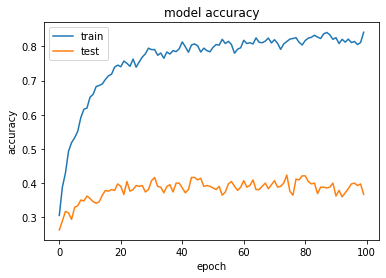

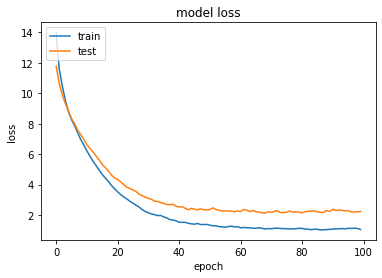

0.39503386004514673
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 199, 256)          357376    
_________________________________________________________________
batch_normalization_1 (Batch (None, 199, 256)          1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 256)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50944)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50944)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1630240   
_________________________________________________________________
dropout_3 (Dropout)          (None

In [11]:
def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train, 4)
    test_target = keras.utils.to_categorical(y_test, 4)
    
    model = rnn(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc = predict(model,test_example,test_target)
    print(acc)
    model.summary()
    return acc

acc = RNN(x_train,y_train,x_test,y_test)